In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
data=datasets.EuroSAT(
    root='data',
    transform=ToTensor(),
    download=True
)

100%|██████████| 94.3M/94.3M [00:00<00:00, 303MB/s]


In [ ]:
len(data)

27000

In [ ]:
from torch.utils.data import random_split
train_size = int(0.75 * len(data))
test_size = len(data) - train_size
train_data, test_data = random_split(data, [train_size, test_size])

In [ ]:
len(train_data),len(test_data)

(20250, 6750)

In [ ]:
image,target=train_data[0]
image.shape

torch.Size([3, 64, 64])

In [ ]:
classes_id=data.class_to_idx
classes_id

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [ ]:
classes=data.classes
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

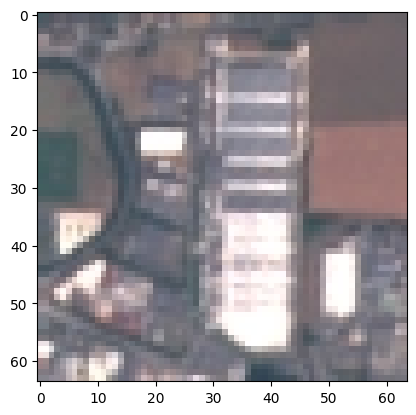

In [ ]:
import matplotlib.pyplot as plt
im_np=image.permute(1,2,0).numpy()
plt.imshow(im_np)

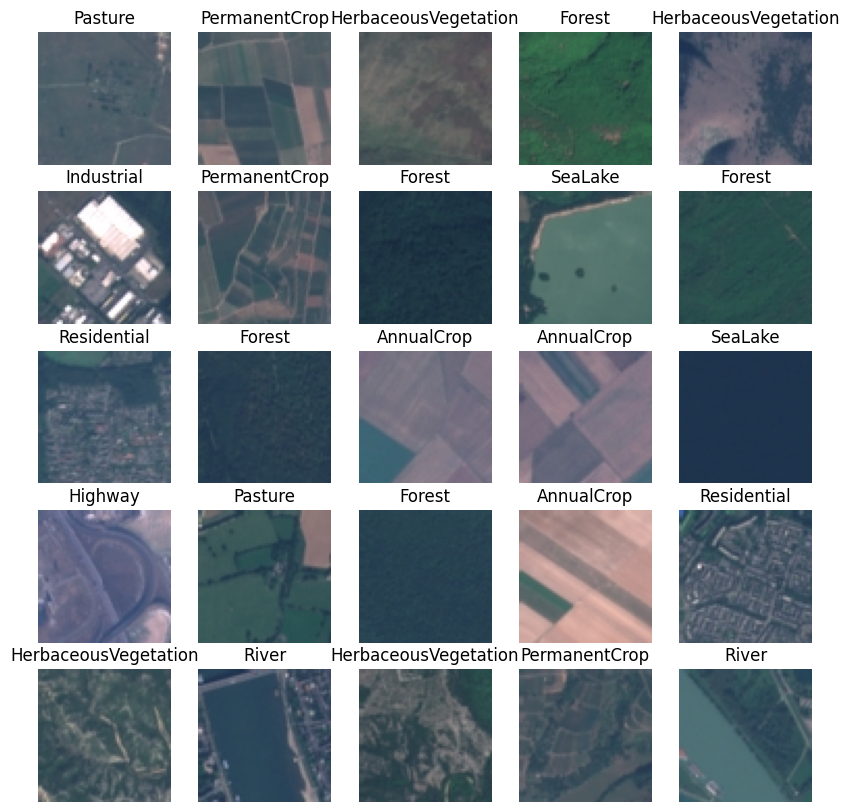

In [ ]:
fig=plt.figure(figsize=(10,10))
r,c=5,5
for i in range(1,r*c+1):
  rand=torch.randint(0,len(data),size=(1,)).item()
  img,label=data[rand]
  fig.add_subplot(r,c,i)
  plt.imshow(img.permute(1,2,0).numpy())
  plt.title(classes[label])
  plt.axis('off')

In [ ]:
from torch.utils.data import DataLoader

BATCH=128

training=DataLoader(
    dataset=train_data,
    batch_size=BATCH,
    shuffle=True
)

testing=DataLoader(
    dataset=test_data,
    batch_size=BATCH,
    shuffle=False
)

In [ ]:
len(training),len(testing)

(159, 53)

In [ ]:
class EuroSATclassification(nn.Module):
  def __init__(self,input_shape,hidden_layers,output_shape):
    super().__init__()
    self.layer1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=hidden_layers,kernel_size=3,stride=2,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_layers,out_channels=hidden_layers,kernel_size=3,stride=2,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=1)
    )
    self.layer2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_layers,out_channels=hidden_layers,kernel_size=3,stride=2,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_layers,out_channels=hidden_layers,kernel_size=3,stride=2,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=1)
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_layers*3*3,out_features=output_shape)
    )
  def forward(self,x):
    return self.classifier(self.layer2(self.layer1(x)))

In [ ]:
model=EuroSATclassification(3,32,len(classes))

In [ ]:
model

EuroSATclassification(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=288, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn=nn.CrossEntropyLoss()
optim=torch.optim.SGD(params=model.parameters(),lr=0.01,momentum=0.9)

In [ ]:
from tqdm.auto import tqdm
from sklearn import metrics
torch.manual_seed(69)

epochs=30

for epoch in tqdm(range(epochs)):
  train_loss=0
  for batch,(X,y) in enumerate(training):
    model.train()
    y_preds=model(X)
    loss=loss_fn(y_preds,y)
    train_loss+=loss
    optim.zero_grad()
    loss.backward()
    optim.step()

    if batch%300==0:
      print(f"Looked at {batch * len(X)}/{len(training.dataset)} samples")
  train_loss/=len(training)
  test_loss=0
  test_accuracy=0
  model.eval()
  with torch.inference_mode():
    for X,y in testing:
      test_preds=model(X)
      loss=loss_fn(test_preds,y)
      test_loss+=loss.item()
      test_accuracy+=metrics.accuracy_score(y.numpy(),test_preds.argmax(dim=1).numpy())
    test_loss /= len(testing)
    test_accuracy /= len(testing)
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%\n")

  0%|          | 0/30 [00:00<?, ?it/s]

Looked at 0/20250 samples

Train loss: 2.14697 | Test loss: 1.79980, Test acc: 0.29%

Looked at 0/20250 samples

Train loss: 1.72053 | Test loss: 1.58856, Test acc: 0.36%

Looked at 0/20250 samples

Train loss: 1.48871 | Test loss: 1.31251, Test acc: 0.47%

Looked at 0/20250 samples

Train loss: 1.21726 | Test loss: 1.09576, Test acc: 0.56%

Looked at 0/20250 samples

Train loss: 1.01553 | Test loss: 1.01182, Test acc: 0.63%

Looked at 0/20250 samples

Train loss: 0.86243 | Test loss: 0.91116, Test acc: 0.66%

Looked at 0/20250 samples

Train loss: 0.77864 | Test loss: 0.86390, Test acc: 0.69%

Looked at 0/20250 samples

Train loss: 0.70712 | Test loss: 0.63603, Test acc: 0.77%

Looked at 0/20250 samples

Train loss: 0.65289 | Test loss: 0.69135, Test acc: 0.75%

Looked at 0/20250 samples

Train loss: 0.64601 | Test loss: 0.72753, Test acc: 0.73%

Looked at 0/20250 samples

Train loss: 0.60071 | Test loss: 0.54749, Test acc: 0.80%

Looked at 0/20250 samples

Train loss: 0.54792 | Test 

In [ ]:
from sklearn.metrics import classification_report

# After training loop finishes
all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y in testing:
        preds = model(X)
        all_preds.extend(preds.argmax(dim=1).numpy())
        all_labels.extend(y.cpu().numpy())

# Generate classification report
print(classification_report(all_labels, all_preds, target_names=classes))


                      precision    recall  f1-score   support

          AnnualCrop       0.87      0.87      0.87       736
              Forest       0.97      0.95      0.96       775
HerbaceousVegetation       0.88      0.66      0.75       757
             Highway       0.80      0.69      0.74       576
          Industrial       0.95      0.87      0.91       590
             Pasture       0.70      0.92      0.80       497
       PermanentCrop       0.63      0.81      0.71       631
         Residential       0.93      0.94      0.94       770
               River       0.81      0.77      0.79       642
             SeaLake       0.96      0.99      0.98       776

            accuracy                           0.85      6750
           macro avg       0.85      0.85      0.84      6750
        weighted avg       0.86      0.85      0.85      6750

